In [1]:
# Import
import pandas as pd
from finta import TA as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
import sqlalchemy as sql
from sklearn.ensemble import RandomForestClassifier

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier


# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)


In [5]:
# Loads the data from the CSV files for Bitcoin and 4 alt coins and creates the dataframes for the coin prices.  
# 
# Because the model using bitcoin, the alt coins have been removed, but can be added if desired.

tickers = ["BTC"]
closing_prices_df = pd.DataFrame()
for ticker in tickers:

    ticker1 = ticker
    ticker2 = "USDT"
    
    pair= "{}{}".format(ticker1,ticker2)
    dataframe_name = "df_{}".format(pair)
    start="2019.1.1"
    end = "2022.4.1"
    filepath = "Resources/{}_{}_to_{}.csv".format(pair,start,end)
    dataframe_name = pd.read_csv(Path(filepath), index_col= "Date", parse_dates= True, infer_datetime_format = True)
    if pair == "BTCUSDT":
        df_BTCUSDT = dataframe_name
    # elif pair == "LTCUSDT":
    #     df_LTCUSDT = dataframe_name
    # elif pair == "ETHUSDT":
    #     df_ETHUSDT = dataframe_name
    # elif pair == "ADAUSDT":
    #     df_ADAUSDT = dataframe_name
    # elif pair == "THETAUSDT":
    #     df_THETAUSDT = dataframe_name

    closing_prices_df[pair] = dataframe_name["Close"]

In [7]:
# In order to prioritize the alts to investigate, the assumption is that the coin with the highest correlation to Bitcoin will have the best returns using the Bitcoin trained model.
# Determine altcoin correlation to BTC.
# Take price data and see if we have a positive or negitive correlation.
# This cell is used when more than one coin is used.  Currently, it is not needed because only bitcoin is being used.
display(closing_prices_df.dropna().head())
close_matrix = closing_prices_df.corr()
print(close_matrix)


,BTCUSDT
Date,
2019-01-01 00:00:00,3700.31
2019-01-01 01:00:00,3689.69
2019-01-01 02:00:00,3690.00
2019-01-01 03:00:00,3693.13
2019-01-01 04:00:00,3692.71


         BTCUSDT
BTCUSDT      1.0


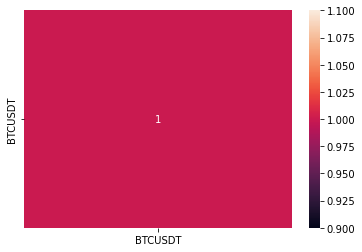

In [8]:
# Create a heat map of the correlation.

# If multiple coins are used this provides a matrix to view the correlation matrix.

sn.heatmap(close_matrix, annot=True)
plt.show()

In [10]:
# This function is used to append each of the technical indicators in the code block below to the dataframes created above.

def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

In [11]:
## Relative Strenght Index is displayed as an oscillator having a range from 0-100, the traditional usage is that anything
## above 70 is an indication of being overbought, where as anything below 30 is being oversold
df_BTCUSDT = appendData(df_BTCUSDT,ta.RSI(df_BTCUSDT))

## stochastic oscillator is an indicator that measures momentum, by comparing a securities closing price over a range
## of time. It takes a moving average of that range and generates an overbought or oversold signal utilizing a 0-100 
## range. The stochastic oscilattor uses a 14 day period, it uses the following to caculate:
## The most recent closing price
## The lowest price traded of the 14 previous trading sessions
## The highest price traded during the same 14-day period
## The current value of the stochastic indicator
df_BTCUSDT = appendData(df_BTCUSDT,ta.STOCH(df_BTCUSDT))

## Average directional index works with the next indicator, directional movement index, ADX is used to observe the strenght of DMI,
## when ADX is above around 25 the trend has strenght and when ADX is below 25 ADX is weak. The trend is found in DMI when DI+ is above
## DI- it is seen as upward pressure and when DI- is above DI+ is it negative pressure.
df_BTCUSDT = appendData(df_BTCUSDT,ta.ADX(df_BTCUSDT))
## DMI (Added to aid in interpreting ADX)
df_BTCUSDT = appendData(df_BTCUSDT,ta.DMI(df_BTCUSDT, 14))
## Awesome
## MACD is caculated by taking 26 period EMA and subtracting it by the 12 period EMA which results in MACD signal line
## MACD signal is triggered when the MACD line crosses over or under the MACD signal line, when it crosses over it is
## a buy signal and when it crosses under it is a sell signal
df_BTCUSDT = appendData(df_BTCUSDT,ta.MACD(df_BTCUSDT)).rename(columns={"SIGNAL": "MACD SIGNAL"})

## SMA, EMA
## SMA caculates the number of averages of a range of prices, in our model we use sma for 5, 10, 20, 30, 50, 100, 200
## EMA is similar to the SMA the main difference is that it gives more weight to the recent price data
## in our model we use sma and ema for 5, 10, 20, 30, 50, 100, 200
sma_ema_averages = [5, 10, 20, 30, 50, 100, 200]
for i in sma_ema_averages:
    df_BTCUSDT = appendData(df_BTCUSDT,ta.SMA(df_BTCUSDT, i))
    df_BTCUSDT = appendData(df_BTCUSDT,ta.EMA(df_BTCUSDT, i))
## BBANDS
## Bollinger bands are comprised of three lines the upper, middle and lower, the middle represents the moving average, and the upper and lower and set by the stanardard deviation
## and are positioned below and above the moving average
df_BTCUSDT = appendData(df_BTCUSDT,ta.BBANDS(df_BTCUSDT))



In [12]:
# Creates a SQL database to hold the results from the classification reports created in the loop structure below.
# Note:  Using BLOB fields is not terribly efficient from a database perspective.  Should probably be VAR. 

database_connection_string = 'sqlite:///'
engine = sql.create_engine(database_connection_string, echo=True)
sql_statement = """
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )
"""
result = engine.execute(sql_statement)

2022-04-16 20:32:01,010 INFO sqlalchemy.engine.Engine 
CREATE TABLE crypto_outcome (
  column_name BLOB,
  _0_precision BLOB,
  _1_precision BLOB,
  _0_recall BLOB,
  _1_recall BLOB,
  _0_f1 BLOB,
  _1_f1 BLOB,
  _0_support BLOB,
  _1_support BLOB,
  _accuracy BLOB
  )

2022-04-16 20:32:01,010 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-04-16 20:32:01,011 INFO sqlalchemy.engine.Engine COMMIT


In [13]:
# This block contains the primary variables used through the for and while loops below.  
## models_list is a list of the machine learning models that will be used.  Remember that if you want to add a model here, it will need to be imported in the import block above.
## percent_threshold is the amount that the underlying must change over the period before a buy signal is created.  
## investment_amount is used to determine the dollar change in the portfolio
## training_length is measured in months to determine how much of the dataset is used for training vs testing.  Here it is 18 months of the two years of data.
## start_period is the smallest number of trading periods iterated through and used to create a signal.  Because our bitcoin data is hourly, this 15 equals 15 hours.
## end_period is the is the largest number of trading periods iterated through and used to create a signal.  Because our bitcoin data is hourly, this 30 equals 30 hours.

## Important - If the percent_threshold is set too high for the start_period, an error may be created.  That is because there are no instances where the percent_threshold was met in that amount of time.  So, for example, an error would likely result if the percent_threshold was .1 (10%) and the start_period was 1 because there is no instance where the underlying moved 10% in one hour.


models_list = [KNeighborsClassifier(n_neighbors=3), SVC(), RandomForestClassifier(), AdaBoostClassifier()] 
percent_threshold = .005
investment_amount = 10000
training_length = 18
start_period = 15
end_period = 30 

In [14]:
#  For each of the models in the list above and for each period, the while loop will scale, fit, train, predict, and output the results to a classification report stored in the SQL database.



for m in models_list:
    model = m
    i = start_period
    i_end = end_period
    while i <= i_end:
        column_name = str(m) + str(i) + "_period_return"
        df_BTCUSDT[column_name] = df_BTCUSDT["Close"].pct_change(periods=-i)

        # Initialize the new `Signal` column
        signal_column_name_training = str(m) + str(i) + "_signal"
        df_BTCUSDT[signal_column_name_training] = 0.0
        # Generate signal to buy stock long
        df_BTCUSDT.loc[(df_BTCUSDT[column_name] >= (percent_threshold)), signal_column_name_training] = 1
        # Drop all NaN values from the DataFrame
        df_BTCUSDT = df_BTCUSDT.dropna()
        y = df_BTCUSDT[signal_column_name_training]
        # set up X for ml 
        X = df_BTCUSDT[['14 period RSI', '14 period STOCH %K', '14 period ADX.', 'DI+', 'DI-', 'MACD', 'MACD SIGNAL', '5 period SMA', '5 period EMA', '10 period SMA', '10 period EMA', '20 period SMA', '20 period EMA', '30 period SMA', '30 period EMA', '50 period SMA', '50 period EMA', '100 period SMA', '100 period EMA', '200 period SMA', '200 period EMA', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER']].shift().dropna().copy()
        y_count = y.value_counts()
        training_begin = X.index.min()
        # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
        training_end = X.index.min() + DateOffset(months=training_length)
        # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
        # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]

        # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
        # Hint: Use `loc[training_end:]` for X_test and y_test
        X_test = X.loc[training_end:]
        y_test = y.loc[training_end:]

        # Use StandardScaler to scale the X_train and X_test data.
        scaler = StandardScaler()
        X_scaler = scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)

        # Fit the model to the data using X_train_scaled and y_train
        model = model.fit(X_train_scaled, y_train)

        # Use the trained model to predict the trading signals for the training data.
        training_signal_predictions = model.predict(X_train_scaled)

        # Evaluate the model using a classification report
        training_report_train = classification_report(y_train, training_signal_predictions)
        #print(column_name)
        #print("Training Report")
        #print(training_report_train)

        # Use the trained model to predict the trading signals for the testing data.
        testing_signal_predictions = model.predict(X_test_scaled)
        predictions_df = pd.DataFrame(index=X_test.index)
        signal_column_name_predictions = str(m) + str(i) + "_signal" + "_predictions"
        predictions_df[signal_column_name_predictions] = 0.0
        predictions_df[signal_column_name_predictions] = testing_signal_predictions

        # Evaluate the model's ability to predict the trading signal for the testing data using a classification report
        #training_report_test = classification_report(y_test, testing_signal_predictions)

        reportdf = pd.DataFrame(classification_report(y_test, testing_signal_predictions, output_dict=True)).transpose()
        
        engine.execute("INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)", (column_name, reportdf['precision'][0], reportdf['precision'][1], reportdf['recall'][0], reportdf['recall'][1], reportdf['f1-score'][0], reportdf['f1-score'][1],reportdf['support'][0], reportdf['support'][1], reportdf['precision'][2]))
       
       
        i+=1
    
sql_query = """
SELECT *
FROM crypto_outcome
"""
outcome = pd.read_sql_query(sql_query, engine, index_col='column_name')
outcome


2022-04-16 20:32:12,560 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-16 20:32:12,561 INFO sqlalchemy.engine.Engine [raw sql] ('KNeighborsClassifier(n_neighbors=3)15_period_return', 0.7435158501440923, 0.3740743511107787, 0.13356802650652308, 0.9182886522218142, 0.22645484069165275, 0.5315971299495085, 9658.0, 5446.0, 0.4165121822033898)
2022-04-16 20:32:12,561 INFO sqlalchemy.engine.Engine COMMIT
2022-04-16 20:32:17,190 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?,?)
2022-04-16 20:32:17,191 INFO sqlalchemy.engine.Engine [raw sql] ('KNeighborsClassifier(n_neighbors=3)16_period_return', 0.75, 0.37630792227204785, 0.13307708290047787, 0.9218235078725742, 0.22604552673372152, 0.5344443265046174, 9626.0, 5462.0, 0.418610816542948)
2022-04-16 20:32:17,191 INFO sqlalchemy.engine.Engine COMMIT
2022-04-16 20:32:21,970 INFO sqlalchemy.engine.Engine INSERT INTO crypto_outcome VALUES (?, ?, ?, ?,

,_0_precision,_1_precision,_0_recall,_1_recall,_0_f1,_1_f1,_0_support,_1_support,_accuracy
column_name,,,,,,,,,
KNeighborsClassifier(n_neighbors=3)15_period_return,0.743516,0.374074,0.133568,0.918289,0.226455,0.531597,9658.0,5446.0,0.416512
KNeighborsClassifier(n_neighbors=3)16_period_return,0.750000,0.376308,0.133077,0.921824,0.226046,0.534444,9626.0,5462.0,0.418611
KNeighborsClassifier(n_neighbors=3)17_period_return,0.744630,0.378499,0.130367,0.922154,0.221886,0.536707,9573.0,5498.0,0.419216
KNeighborsClassifier(n_neighbors=3)18_period_return,0.747119,0.382423,0.129548,0.924770,0.220808,0.541088,9510.0,5543.0,0.422374
KNeighborsClassifier(n_neighbors=3)19_period_return,0.726347,0.385139,0.128632,0.918451,0.218559,0.542704,9430.0,5604.0,0.423041
KNeighborsClassifier(n_neighbors=3)20_period_return,0.733614,0.384540,0.129278,0.920567,0.219820,0.542477,9437.0,5577.0,0.423205
KNeighborsClassifier(n_neighbors=3)21_period_return,0.728351,0.387240,0.130889,0.918375,0.221901,0.544772,9382.0,5611.0,0.425599
KNeighborsClassifier(n_neighbors=3)22_period_return,0.746538,0.388805,0.132267,0.924768,0.224719,0.547445,9375.0,5596.0,0.428495
KNeighborsClassifier(n_neighbors=3)23_period_return,0.746437,0.392039,0.134857,0.924116,0.228442,0.550527,9321.0,5627.0,0.431964


In [15]:
# Because the above can be voluminous, this filter can return only those that meet the desired threshold.  
# Available column names are: _0_precision, _1_precision, _0_recall, _1_recall, _0_f1, _1_f1, _0_support, _1_support, and _accuracy


filter_column = "_1_f1"
filter_threshold = .56

outcome_filtered = outcome[outcome[filter_column] > filter_threshold]

outcome_filtered

,_0_precision,_1_precision,_0_recall,_1_recall,_0_f1,_1_f1,_0_support,_1_support,_accuracy
column_name,,,,,,,,,
SVC()26_period_return,0.774806,0.398564,0.122674,0.942217,0.211812,0.560172,8975.0,5538.0,0.435403
SVC()30_period_return,0.780105,0.398714,0.117231,0.946565,0.203830,0.561086,8897.0,5502.0,0.434127


,SVC()30_signal_predictions,signal,model_period_return,signal_2,actual_return,algo_model,algo_cumulative_returns,actual_cumulative_returns
Date,,,,,,,,
2022-01-29 14:00:00,1.0,1.0,NaN,0.0,-0.014194,0.0,-0.525492,3.001144
2022-01-29 15:00:00,1.0,1.0,NaN,0.0,-0.001415,0.0,-0.525492,2.995484
2022-01-29 16:00:00,1.0,1.0,NaN,0.0,-0.000762,0.0,-0.525492,2.992439
2022-01-29 17:00:00,1.0,1.0,NaN,0.0,0.002880,0.0,-0.525492,3.003938
2022-01-29 18:00:00,1.0,1.0,NaN,0.0,0.004248,0.0,-0.525492,3.020947


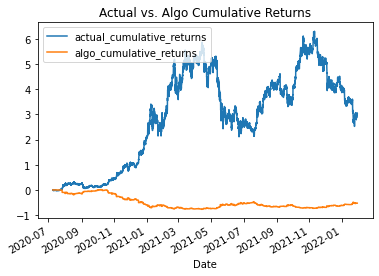

In [16]:
# Using the above filtered chart, select a model and duration and enter them below.  This will run the model and produce the return.  
# In a future iteration of this project, this could be incorporated in the above step, but to retain the ability to select the column and duration, it is separated out and re-run.
# Also, for future consideration, it strangely appears that our model is actually inverse to the results.  As BTC goes up, our results get worse and vice versa.

selected_model = [SVC()]
selected_duration = 30

# Runs the model using the selected model and time period.
for m in selected_model:
    model = m
    i = selected_duration
    i_end = selected_duration
    while i <= i_end:
        column_name = str(m) + str(i) + "_period_return"
        df_BTCUSDT[column_name] = df_BTCUSDT["Close"].pct_change(periods=-i)

        # Initialize the new `Signal` column
        signal_column_name_training = str(m) + str(i) + "_signal"
        df_BTCUSDT[signal_column_name_training] = 0.0
        # Generate signal to buy stock long
        df_BTCUSDT.loc[(df_BTCUSDT[column_name] >= (percent_threshold)), signal_column_name_training] = 1
        # Drop all NaN values from the DataFrame
        df_BTCUSDT = df_BTCUSDT.dropna()
        y = df_BTCUSDT[signal_column_name_training]
        # set up X for ml 
        X = df_BTCUSDT[['14 period RSI', '14 period STOCH %K', '14 period ADX.', 'DI+', 'DI-', 'MACD', 'MACD SIGNAL', '5 period SMA', '5 period EMA', '10 period SMA', '10 period EMA', '20 period SMA', '20 period EMA', '30 period SMA', '30 period EMA', '50 period SMA', '50 period EMA', '100 period SMA', '100 period EMA', '200 period SMA', '200 period EMA', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER']].shift().dropna().copy()
        y_count = y.value_counts()
        training_begin = X.index.min()
        # Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
        training_end = X.index.min() + DateOffset(months=training_length)
        # Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
        # Hint: Use `loc[training_begin:training_end]` for X_train and y_train
        X_train = X.loc[training_begin:training_end]
        y_train = y.loc[training_begin:training_end]

        # Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
        # Hint: Use `loc[training_end:]` for X_test and y_test
        X_test = X.loc[training_end:]
        y_test = y.loc[training_end:]

        # Use StandardScaler to scale the X_train and X_test data.
        scaler = StandardScaler()
        X_scaler = scaler.fit(X_train)
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)

        # Fit the model to the data using X_train_scaled and y_train
        model = model.fit(X_train_scaled, y_train)

        # Use the trained model to predict the trading signals for the training data.
        training_signal_predictions = model.predict(X_train_scaled)

        # Use the trained model to predict the trading signals for the testing data.
        testing_signal_predictions = model.predict(X_test_scaled)
        predictions_df = pd.DataFrame(index=X_test.index)
        signal_column_name_predictions = str(m) + str(i) + "_signal" + "_predictions"
        predictions_df[signal_column_name_predictions] = 0.0
        predictions_df[signal_column_name_predictions] = testing_signal_predictions

        i+=1

# set period as the negative of the duration
period = -1*selected_duration

# pull BTC returns into the predictions
df_BTCUSDT["actual_return"] = df_BTCUSDT["Close"].pct_change()
predictions_df["signal"] = predictions_df[signal_column_name_predictions]

predictions_df["model_period_return"] = df_BTCUSDT["Close"].pct_change(periods=i)

# This loops through and restricts signal_2 to one buy signal within the period
outer_counter = 0
for index, row in predictions_df.iterrows():
    if predictions_df.at[index, "signal"] == 1.0 and outer_counter ==0:
        predictions_df.at[index, "signal_2"] = predictions_df.at[index, "signal"]
        outer_counter = outer_counter + 1
    elif outer_counter > 0 and outer_counter < (period * -1):
        predictions_df.at[index, "signal_2"] = 0
        outer_counter = outer_counter + 1
    elif outer_counter == (period * -1):
        outer_counter = 0

predictions_df["signal_2"].fillna(0,inplace=True)
predictions_df["model_period_return"] = df_BTCUSDT["Close"].pct_change(periods=period)
# # # Add in actual returns and calculate trading returns
predictions_df['actual_return'] = df_BTCUSDT['actual_return']
predictions_df['algo_model'] = predictions_df.loc[predictions_df["signal_2"]==1]["model_period_return"]
predictions_df["algo_model"].fillna(0,inplace=True)
predictions_df["algo_cumulative_returns"] = (1 + predictions_df["algo_model"]).cumprod() - 1
predictions_df["actual_cumulative_returns"] = (1 + predictions_df["actual_return"]).cumprod() - 1
predictions_df.dropna()

# Displays the plot and the tail for the predictions dataframe
predictions_df[["actual_cumulative_returns","algo_cumulative_returns"]].plot(title="Actual vs. Algo Cumulative Returns")
predictions_df.tail()